<a href="https://colab.research.google.com/github/ntnrgtic/Bicycle_Dynamics/blob/main/Decision_Tree_Practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# APL405: Machine Learning for Mechanics (Practical on Decision Trees)
**Instructor**: [Rajdip Nayek](https://https://sites.google.com/view/rajdip-nayek/team?authuser=0)

## Classifying a stiff from a non-stiff spring
Consider a synthetic binary classification problem (two classes) with a given experimental dataset having $N = 30$ (statistically independent) observations of $2$-dimensional input variables $\mathbf{x} = [x_1 \;\; x_2]^T$ and one categorical output $y$, representing either $\mathtt{Stiff}$ or $\mathtt{Non-Stiff}$ linear elastic spring. A series of experiments were carried out on the two classes of springs. In an experiment, a block of known weight $w$ kg $(x_1)$  would be vertically hung from one end of the spring, and the corresponding stretch $d$ mm $(x_2)$ of the spring would be noted. 

Download the experimental dataset of 30 input-output pairs from $\mathtt{spring\_ stiffness\_classify.h5}$ file from the [course website](https://github.com/coursesAM/APL405/blob/main/Practicals/Datasets/spring_stiffness_classify.h5) and load it on colab drive. You should see your file on the left panel under "Files" 

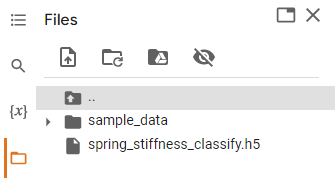

In [ ]:
# import relevant libraries
import math
import h5py
from matplotlib import pyplot as plt

In [ ]:
data = h5py.File('spring_stiffness_classify.h5','r')
dataset = data.get('dataset')    
print(dataset)

<HDF5 dataset "dataset": shape (30, 3), type "<f8">


(a) **Data Visualization**: The dataset has two columns for inputs and a third column for output classes for spring type (taken as 0 - Non-stiff and 1 - Stiff). 

---


Plot the dataset in two dimensions and use circular markers (blue and red) to denote the two different classes [*2 marks*]


---



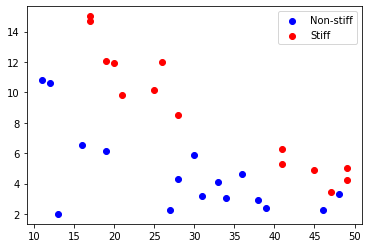

In [ ]:
# Sort the dataset into two lists
# Each list should contain data belonging to the particular class
class1 = [] # should have dataset only belonging to non-stiff spring
class2 = [] # should have dataset only belonging to stiff spring
for i in range(len(dataset)):
  if dataset[i][-1] == 0:
      class1.append(dataset[i])
  else:
      class2.append(dataset[i])

## Features of the data stored in the list
x1 = []
y1 = []
x2 = []
y2 = []
for i in range(len(class1)):
  x1.append(class1[i][0])
  y1.append(class1[i][1])
for i in range(len(class2)):
  x2.append(class2[i][0])
  y2.append(class2[i][1])

## Plot
plt.scatter(x1,y1,color = 'b')
plt.scatter(x2,y2,color = 'r')
plt.legend(['Non-stiff','Stiff'])

# Calculating the Gini index

The Gini index is a loss function that can be used to evaluate splits in the dataset. A split in the dataset involves one input feature and one value for that input feature. It can be used to divide training data into two regions (each region containing a set of observations in the form of rows).

A Gini score gives an idea of how good a split is by how mixed the classes are in the two regions created by the split. A perfect separation results in a Gini score of 0, whereas the worst case split that results in 50/50 classes in each group results in a Gini score of 0.5 (for a 2 class problem).

$\mathtt{Gini \;\;index}: Q_{\ell} = \sum_{m=1}^M \hat{\pi}_{\ell, m}(1-\hat{\pi}_{\ell, m}) = 1 - \sum_{m=1}^M \hat{\pi}_{\ell, m}^2$; 

$\hat{\pi}_{\ell, m}$ is the proportion of observations in that belong to $m$th class and $\ell$th region

(b) Write a function to calculate the Gini index for a list of regions and a list of known class values. Also test your Gini index function if it works fine  [*5 marks*]


In [ ]:
def gini_index(regions, classes):

	# regions: two regions containing a list of input points and their corresponding classes 
  # classes: list of M classes denoted as 0,1,...,M

  # sum weighted Gini index for each region
	gini_score = 0.0
	for region in regions:
		size = float(len(region))
  
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0

		# Gini score for the region based on the Gini score for each class
		for class_val in classes:
			p = [row[-1] for row in region].count(class_val) / size
			score += p * p

		# weight the group score by its relative size
		gini_score += (1.0 - score) * size 
		
	
	return gini_score

In [ ]:
# Test your Gini index
print(gini_index([class1, class2], [0, 1])) # should output 0.0


0.0


# Splitting a dataset at root node

Splitting a dataset means separating a dataset into two lists (i.e. regions) of rows given the index of an input feature and a threshold value for that feature. Once we have the two regions, we can then use our Gini score above to evaluate the cost of the split. Splitting a dataset involves iterating over each row, checking if the input feature value is below or above the threshold value and assigning it to the left or right region respectively.


(c) Write a function $\mathtt{split\_node}$ function to split a dataset into two (left and right) lists (representing regions) of data [*3 marks*]

In [ ]:
# Split a dataset based on an input feature and a input feature value

def split_at_root_node(feature_index, value, dataset):

	left, right = list(), list() # initialize lists

	for row in dataset:

		if row[feature_index] < value:
			left.append(row)
		else:
			right.append(row)
	 
	return left, right

# Finding the best split at a node

With the help of a loss function (e.g. Gini index) and the splitting function we now have everything we need to evaluate splits. Given a dataset, we must check every value on each input feature as a candidate split, evaluate the cost of the split and find the best possible split we could make. Once the
best split is found, we can use it as a node in our decision tree. 

We will use a dictionary to represent a node in the decision tree as we can store data by name. When selecting the best split and using it as a new node for the tree we will store the index of the chosen input feature, the value of that input feature by which to split and the two groups of data split by the chosen split point.

Each region will have its own small dataset of just those rows assigned to the left or right region by the splitting process. You can imagine how we might split each region again, recursively as we build out our decision tree.

(d) Write a function $\mathtt{get\_best\_split}$ to evaluate various splits and output the best split [*5 marks*]

In [ ]:
# Select the best split point for a given dataset
def get_best_split(dataset):

	# Find the different classes present in the dataset
	class_values = list(set(row[-1] for row in dataset)) 
 
 	# initialize best_index, best_threshold, best_gini_score, best_regions
	best_index 			= 999
	best_value		 	= 999
	lowest_loss 		= 999
	best_regions 		= None

	# write an outer loop for going over all input feature index
	# write an inner loop 

	total_input_features = len(dataset[0])-1	# total input features x_1, x_2, ...
 
	for input_index in range(total_input_features): # looping over feature index

		for row in dataset: # looping over feature values

			# get left and right regions
			regions = split_at_root_node(input_index, row[input_index], dataset)
	 
	 		# evaluate Gini index for the split
			gini_loss = gini_index(regions, class_values)
	 
			print('X%d < %.3f Gini=%.3f' % ((input_index+1), row[input_index], gini_loss))
	 
			if gini_loss < lowest_loss:
				best_index 			= input_index
				best_value 			= row[input_index]
				lowest_loss    	= gini_loss
				best_regions 		= regions
				
	return {'index':best_index, 'value':best_value, 'regions':best_regions}


In [ ]:
# Test your text_split()
print(get_best_split(dataset))  

# Stopping criteria
We need to decide when to stop growing a tree. We can do that using the depth and the number of rows (or data points) in a node is responsible for in the training dataset.

*   **Maximum Tree Depth**
This is the maximum number of nodes from the root node of the tree. Once a maximum depth of the tree is met, we must stop adding new nodes. Deeper trees are more complex and are more likely to overfit the training data.

*   **Minimum number of training observations in an internal node**
This is the minimum number of training patterns that a given internal node harbors. Once at or below this minimum, we must stop splitting and
adding new nodes. 

Now we have some ideas of when to stop growing the tree. When we do stop growing at a given point, that node is called a *leaf* and is used to make a final prediction. This is done by taking the group of rows assigned to the leaf and selecting the most common class value in the group. This will be used to make predictions. 

(e) Write a function $\mathtt{leaf}$ that will select a class value for a region (i.e. group of rows). It should return the most common output value in a list of rows [*2 marks*]

In [ ]:
# Create a leaf value
def leaf_output(region):
  outcomes = [row[-1] for row in region]
  return max(set(outcomes), key=outcomes.count)

# Building a tree using Recursive Splitting Algorithm

We know how and when to create leaf nodes; now we can build our tree. Building a
decision tree involves calling the above developed $\mathtt{get\_best\_split}$ function over and over again on the regions created for each node. 

New nodes added to an existing node are called *internal* nodes. An internal node may be a leaf node plus an internal child node (the leaf node side makes a prediction directly) or two internal child nodes. We will refer to the child nodes as left and right in the dictionary representation of a given internal node. Once a node is created, we can create child nodes recursively on each group of data from the split by calling the same function again. 


(f) Write a function that implements the recursive splitting algorithm. It takes a node as an argument as well as the maximum depth, minimum number of
observations in a node and the current depth of an internal node. [*7 marks*]


In [ ]:
# Creates internal child splits for a node or make a leaf node
def split(internal_node, max_depth, min_size, depth):

	left, right = internal_node['regions']

	del(internal_node['regions'])
 
	# check for no split
	if not left or not right:
		internal_node['left'] = internal_node['right'] = leaf_output(left + right)
		return

	# check for max depth
	if depth >= max_depth:
		internal_node['left'], internal_node['right'] = leaf_output(left), leaf_output(right)
		return

	# process left child
	if len(left) <= min_size:
		internal_node['left'] = leaf_output(left)
	else:
		internal_node['left'] = get_best_split(left)
		split(internal_node['left'], max_depth, min_size, depth+1)
  
	# process right child
	if len(right) <= min_size:
		internal_node['right'] = leaf_output(right)
	else:
		internal_node['right'] = get_best_split(right)
		split(internal_node['right'], max_depth, min_size, depth+1)

(g) Write a function that builds and prints the tree. [*5 marks*]


In [ ]:
# Build a decision tree
def build_tree(train, max_depth, min_size):
	root = get_best_split(train)
	split(root, max_depth, min_size, 1)
	return root

In [ ]:
# Print a decision tree
def print_tree(node, depth=0):
	if isinstance(node, dict):
		print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
		print_tree(node['left'], depth+1)
		print_tree(node['right'], depth+1)
	else:
		print('%s[%s]' % ((depth*' ', node)))

In [ ]:
tree = build_tree(dataset, 2, 3)

In [ ]:
print_tree(tree)

[X2 < 3.449]
 [X1 < 34.000]
  [0.0]
  [0.0]
 [X1 < 17.000]
  [0.0]
  [1.0]


# Make predictions using decision tree

Making predictions with a decision tree involves navigating the tree with the specifically provided input data. Again, we can implement this using a recursive function, where the same prediction routine is called again with the left or the right internal child nodes, depending on how the split affects the provided data. We must check if an internal child node is either a leaf value to be returned as the prediction, or if it is an internal node containing another level of the tree to be considered.

(h) Write a function $\mathtt{predict}$ to output prediction for a test input. [*3 marks*]

In [ ]:
# Make a prediction with a decision tree
def predict(node, row):
	if row[node['index']] < node['value']:
		if isinstance(node['left'], dict):
			return predict(node['left'], row)
		else:
			return node['left']
	else:
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']

# Using Sci-kit learn

Scikit learn provides a direct command for creating decision tree.

[Text(0.3333333333333333, 0.9, 'X[1] <= 3.376\ngini = 0.498\nsamples = 30\nvalue = [16, 14]'),
 Text(0.16666666666666666, 0.7, 'gini = 0.0\nsamples = 8\nvalue = [8, 0]'),
 Text(0.5, 0.7, 'X[0] <= 16.5\ngini = 0.463\nsamples = 22\nvalue = [8, 14]'),
 Text(0.3333333333333333, 0.5, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(0.6666666666666666, 0.5, 'X[1] <= 6.215\ngini = 0.388\nsamples = 19\nvalue = [5, 14]'),
 Text(0.5, 0.3, 'X[0] <= 38.5\ngini = 0.5\nsamples = 10\nvalue = [5, 5]'),
 Text(0.3333333333333333, 0.1, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.6666666666666666, 0.1, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(0.8333333333333334, 0.3, 'gini = 0.0\nsamples = 9\nvalue = [0, 9]')]

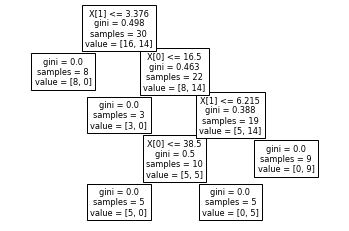

In [ ]:
from sklearn import tree
import h5py

# Data import
data = h5py.File('spring_stiffness_classify.h5','r')
dataset = data.get('dataset')    
X = dataset[:,:2]
Y = dataset[:,2]

# Train
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth = 4)
clf = clf.fit(X, Y)

# Plot
tree.plot_tree(clf)